# Required Libraries

In [1]:
import requests
from IPython.display import JSON
import pandas as pd
import numpy as np
import time

# Visualization
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px

# Panel/hvplot (holoviz)
import panel as pn
pn.extension()
import param
import hvplot.pandas

# Others
import pickle
from io import StringIO

# Get API KEY

In [2]:
from Lib.api_secret import API_KEY

In [3]:
# Submitting file for transcription
import requests
endpoint = "https://api.assemblyai.com/v2/transcript"
json = {
    "audio_url": "https://github.com/jacklvd/Audio_Data_Project/blob/master/How_I_would_learn_to_code_by_Jason_Goodison.mp3?raw=true",
    "auto_highlights" : True,
    "sentiment_analysis" : True,
    "auto_chapters" : True,
    "iab_categories" : True,
}
headers = {
    "authorization": API_KEY,
    "content-type": "application/json"
}
response = requests.post(endpoint, json=json, headers=headers)
print(response.json())

{'id': 'onnohj3htc-2fb0-4ac9-948e-9aa9ecbf0c86', 'language_model': 'assemblyai_default', 'acoustic_model': 'assemblyai_default', 'language_code': 'en_us', 'status': 'queued', 'audio_url': 'https://github.com/jacklvd/Audio_Data_Project/blob/master/How_I_would_learn_to_code_by_Jason_Goodison.mp3?raw=true', 'text': None, 'words': None, 'utterances': None, 'confidence': None, 'audio_duration': None, 'punctuate': True, 'format_text': True, 'dual_channel': None, 'webhook_url': None, 'webhook_status_code': None, 'webhook_auth': False, 'webhook_auth_header_name': None, 'speed_boost': False, 'auto_highlights_result': None, 'auto_highlights': True, 'audio_start_from': None, 'audio_end_at': None, 'word_boost': [], 'boost_param': None, 'filter_profanity': False, 'redact_pii': False, 'redact_pii_audio': False, 'redact_pii_audio_quality': None, 'redact_pii_policies': None, 'redact_pii_sub': None, 'speaker_labels': False, 'content_safety': False, 'iab_categories': True, 'content_safety_labels': {}, '

In [6]:
result_endpoint = endpoint + "/" + response.json()["id"]
headers_auth = {
    "authorization": API_KEY,
}
transcript_response = requests.get(result_endpoint, headers=headers_auth)
print(transcript_response.json())

# While loop for requesting transcription

while response.json()['status'] != 'completed':
    response = requests.get(result_endpoint, headers=headers_auth)
    time.sleep(3)

{'id': 'onnohj3htc-2fb0-4ac9-948e-9aa9ecbf0c86', 'language_model': 'assemblyai_default', 'acoustic_model': 'assemblyai_default', 'language_code': 'en_us', 'status': 'completed', 'audio_url': 'https://github.com/jacklvd/Audio_Data_Project/blob/master/How_I_would_learn_to_code_by_Jason_Goodison.mp3?raw=true', 'text': "This is how I would learn to code if I could start over for context, I work at Microsoft, but before that I did six internships across three countries. So yeah, I've done a line or two in my life. Wait, not like that. What the to tell you what I would change, I first need to tell you what I did. I started coding in great alignment. Eleven. Well, sort of. We started with this language called Scratch. It's basic game development made for children. Nobody would be stupid enough to, let's say, do an entire Google coding interview in this language and maybe even do shots every time the code fails. So let's just skip that and get to the important stuff. I went to Waterloo and in 

In [8]:
JSON(transcript_response.json())

<IPython.core.display.JSON object>

In [9]:
# Save pickle
with open('speech_data.pkl', 'wb') as f:
    pickle.dump(transcript_response.json().copy(), f)

## Dashboard Components

In [10]:
# Load data pickle
with open('speech_data.pkl', 'rb') as f:
    data = pickle.load(f)


### 0) Download transcript widget

In [11]:
# write text into a file buffer
buffer = StringIO()
buffer.write(data["text"])
buffer.seek(0)

0

In [12]:
transcript_download = pn.widgets.FileDownload(file=buffer,
                                              filename="transcript.txt",
                                              button_type="success")
transcript_download

FileDownload(button_type='success', file=<_io.StringIO o..., filename='transcript.txt', label='Download transcript.txt')

### 00) Audio play widget

In [13]:
audio_url = "https://github.com/jacklvd/Audio_Data_Project/blob/master/How_I_would_learn_to_code_by_Jason_Goodison.mp3?raw=true"
audio_play =pn.pane.Audio(audio_url, name='Audio', time = 240)
audio_play

Audio(str, time=240)

### 1) Sentimental Plot

In [14]:
sentiment = data["sentiment_analysis_results"]

In [15]:
sentiment_df = pd.DataFrame(sentiment)
sentiment_df

,text,start,end,sentiment,confidence,speaker
0,This is how I would learn to code if I could s...,130,6982,NEUTRAL,0.534648,None
1,"So yeah, I've done a line or two in my life.",7066,9234,NEUTRAL,0.817905,None
2,"Wait, not like that.",9272,10218,NEGATIVE,0.547122,None
3,"What the to tell you what I would change, I fi...",10244,13794,NEUTRAL,0.739031,None
4,I started coding in great alignment.,13832,14986,POSITIVE,0.886931,None
...,...,...,...,...,...,...
145,They'll help you build and complete an entire ...,536708,540282,POSITIVE,0.853045,None
146,"They're also just really fun, even if the food...",540356,544626,POSITIVE,0.540023,None
147,"Now don't forget, this comes after you learn t...",544688,547678,NEUTRAL,0.701830,None
148,Don't try to program before you know how to co...,547714,553282,NEGATIVE,0.611940,None


In [16]:
# count sentimental words
sentiment_df_grouped = sentiment_df['sentiment'].value_counts()
sentiment_df_grouped

NEUTRAL     99
POSITIVE    31
NEGATIVE    20
Name: sentiment, dtype: int64

In [17]:
# Bar plot
sentiment_plot = sentiment_df_grouped.hvplot(title = "Sentences by Sentiment Category", kind="bar")
pn.Row(sentiment_plot)

Row
    [0] HoloViews(Bars)

In [18]:
# View in details
positive_df = sentiment_df[sentiment_df["sentiment"] == "POSITIVE"][["text", "sentiment"]]
negative_df = sentiment_df[sentiment_df["sentiment"] == "NEGATIVE"][["text", "sentiment"]]
neutral_df = sentiment_df[sentiment_df["sentiment"] == "NEUTRAL"][["text", "sentiment"]]

# Create tabs for viewing
sentiment_tabs = pn.Tabs(('Sentiment Overview', sentiment_plot),
                         ('Positive', pn.widgets.DataFrame(positive_df, autosize_mode='fit_columns', width=700, height=300)),
                         ('Negative', pn.widgets.DataFrame(negative_df, autosize_mode='fit_columns', width=700, height=300)),
                         ('Neutral', pn.widgets.DataFrame(neutral_df, autosize_mode='fit_columns', width=700, height=300))
                        )

sentiment_tabs

Tabs
    [0] HoloViews(Bars, name='Sentiment Overview')
    [1] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [2] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)
    [3] DataFrame(autosize_mode='fit_columns', height=300, sizing_mode='fixed', value=                          ..., width=700)

### 2) Word Cloud

In [20]:
stopwords = set(STOPWORDS)

In [21]:
transcript = data["text"]

In [22]:
transcript_lower = [item.lower() for item in str(transcript).split()]
transcript_lower

['this',
 'is',
 'how',
 'i',
 'would',
 'learn',
 'to',
 'code',
 'if',
 'i',
 'could',
 'start',
 'over',
 'for',
 'context,',
 'i',
 'work',
 'at',
 'microsoft,',
 'but',
 'before',
 'that',
 'i',
 'did',
 'six',
 'internships',
 'across',
 'three',
 'countries.',
 'so',
 'yeah,',
 "i've",
 'done',
 'a',
 'line',
 'or',
 'two',
 'in',
 'my',
 'life.',
 'wait,',
 'not',
 'like',
 'that.',
 'what',
 'the',
 'to',
 'tell',
 'you',
 'what',
 'i',
 'would',
 'change,',
 'i',
 'first',
 'need',
 'to',
 'tell',
 'you',
 'what',
 'i',
 'did.',
 'i',
 'started',
 'coding',
 'in',
 'great',
 'alignment.',
 'eleven.',
 'well,',
 'sort',
 'of.',
 'we',
 'started',
 'with',
 'this',
 'language',
 'called',
 'scratch.',
 "it's",
 'basic',
 'game',
 'development',
 'made',
 'for',
 'children.',
 'nobody',
 'would',
 'be',
 'stupid',
 'enough',
 'to,',
 "let's",
 'say,',
 'do',
 'an',
 'entire',
 'google',
 'coding',
 'interview',
 'in',
 'this',
 'language',
 'and',
 'maybe',
 'even',
 'do',
 'sho

In [23]:
all_words = ''.join(transcript_lower)
all_words

"thisishowiwouldlearntocodeificouldstartoverforcontext,iworkatmicrosoft,butbeforethatididsixinternshipsacrossthreecountries.soyeah,i'vedonealineortwoinmylife.wait,notlikethat.whatthetotellyouwhatiwouldchange,ifirstneedtotellyouwhatidid.istartedcodingingreatalignment.eleven.well,sortof.westartedwiththislanguagecalledscratch.it'sbasicgamedevelopmentmadeforchildren.nobodywouldbestupidenoughto,let'ssay,doanentiregooglecodinginterviewinthislanguageandmaybeevendoshotseverytimethecodefails.solet'sjustskipthatandgettotheimportantstuff.iwenttowaterlooandinorderilearnedfirstracket,thencplusplushtml,css,tcl,python,java,javascript.csharp.someofthesewereinclass,someareontheirown.here'sthemotivationbehindeachracketforrecursion,cformemorymanagement,cforobjectorienteddesign,htmlandcss.forwebdevelopment,althoughthesearenotrealprogramminglanguagesormarkuplanguages.tclididaninternshipandit'suseless.pythonilearnedthisaloneandovertime,butmostlyjustforsideprojectsjavaandjavascript.forbackendandfrontendwebde

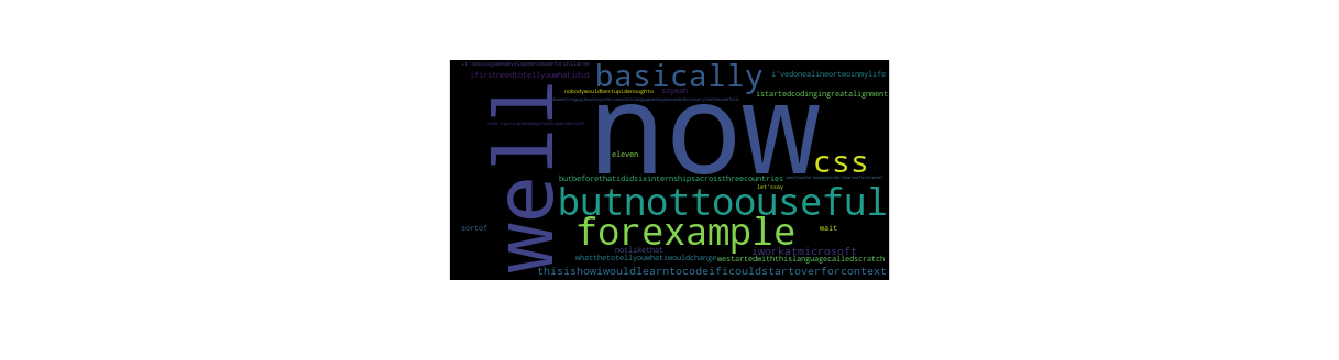

In [35]:
# Word cloud plot
wordcloud = WordCloud(background_color='black', stopwords = stopwords, max_words = 25,
                      colormap='viridis', collocations=False).generate(all_words)

wordcloud_plot = px.imshow(wordcloud)

# to remove x and y axis label
wordcloud_plot.update_xaxes(showticklabels=False)
wordcloud_plot.update_yaxes(showticklabels=False)

wordcloud_plot

In [37]:
# Create interactive slider
class Controller(param.Parameterized):
    word_slider = param.Integer(30, bounds=(5, 50), step=5)
    # update_wordcloud(word_slider)
    
controller = Controller()

@pn.depends(controller.param.word_slider, watch=True)
def update_wordcloud(num_words):
    # Word cloud plot
    wordcloud = WordCloud(background_color='black', stopwords = stopwords, max_words = 20,
                          colormap='viridis', collocations=False).generate(all_words)
    wordcloud_plot = px.imshow(wordcloud)
    # Remove labels on axes
    wordcloud_plot.update_xaxes(showticklabels=False)
    wordcloud_plot.update_yaxes(showticklabels=False)
    return wordcloud_plot

### 3) Auto chapter summary

In [38]:
chapters = data["chapters"]
chapters

[{'summary': "Before working at Microsoft, he did six internships across three countries. He learned C c plus plus, HTML, CSS, TCL, Python, Java, JavaScript and C Sharp. C and C are by far the most useful languages to learn. Coding is just writing code to solve computer science problems. Programming is the act of using coding to make programs that solve real problems. Don't get carried away with learning Python. You don't need to learn advanced things like inheritance exceptions, hash, maps or recursion. There are plenty of interest Python courses in the world, so I'm not going to bore you with the details.",
  'headline': 'He learned C c plus plus, HTML, CSS, TCL, Python, Java, JavaScript and C Sharp.',
  'gist': "Tim's learning curve.",
  'start': 130,
  'end': 260010},
 {'summary': "There are three important aspects to a website: the back end, the front end, which runs on the user's browser, and the database, which essentially stores data. The first program I would build would be a 

In [39]:
chapter_summary = pn.widgets.StaticText(value=chapters[0]["summary"],
                                        width=1000,
                                        height_policy = "fit")
chapter_summary

StaticText(height_policy='fit', value="Before working at Microso..., width=1000)

In [40]:
button= pn.widgets.Button(name=str(int(chapters[0]["start"]/1000)), button_type='primary')
button

Button(button_type='primary', name='0')

In [41]:
chapter_audio = pn.pane.Audio(audio_url, name="Audio", time = round(chapters[0]["start"]/1000))
chapter_audio

Audio(str)

In [49]:
# Create chapter summary layout
chapters_layout = pn.Column(pn.pane.Markdown("### Auto Chapter Summary"))

class ButtonAudio():
    def __init__(self, start_time):
        self.start_time = start_time
        self.button = pn.widgets.Button(name=str(int(self.start_time/1000)), button_type='primary', width=80)
        self.chapter_audio = pn.pane.Audio(audio_url, name='Audio', time = round(self.start_time/1000))
        self.button.on_click(self.move_audio_head)
    
    def move_audio_head(self, event):
        self.chapter_audio.time = self.start_time/1000

for chapter in chapters:
    chapter_summary = pn.widgets.StaticText(value=chapter["summary"], width=1000, height_policy = "fit")
    button_audio = ButtonAudio(chapter["start"])
    button = button_audio.button
    chapter_audio = button_audio.chapter_audio
    chapters_layout.append(pn.Row(pn.Column(button), pn.Column(chapter_audio), pn.Column(chapter_summary)))

chapters_layout

Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] Button(button_type='primary', name='0', width=80)
        [1] Column
            [0] Audio(str)
        [2] Column
            [0] StaticText(height_policy='fit', value="Before working at Microso..., width=1000)
    [2] Row
        [0] Column
            [0] Button(button_type='primary', name='260', width=80)
        [1] Column
            [0] Audio(str, time=260)
        [2] Column
            [0] StaticText(height_policy='fit', value="There are three important..., width=1000)
    [3] Row
        [0] Column
            [0] Button(button_type='primary', name='368', width=80)
        [1] Column
            [0] Audio(str, time=368)
        [2] Column
            [0] StaticText(height_policy='fit', value="It's always best to creat..., width=1000)
    [4] Row
        [0] Column
            [0] Button(button_type='primary', name='480', width=80)
        [1] Column
            [0] Audio(str, time=481)
        [2] Column
            [0] StaticText(height_policy='fit', value="The best and most popular..., width=1000)

### 4) Auto Highlights

In [50]:
highlights = data["auto_highlights_result"]["results"]
highlights_df = pd.DataFrame(highlights)
highlights_df

,count,rank,text,timestamps
0,1,0.08,real programming languages,"[{'start': 51164, 'end': 52174}]"
1,1,0.08,most other programming languages,"[{'start': 74782, 'end': 76162}]"
2,1,0.07,most other languages,"[{'start': 495176, 'end': 496186}]"
3,1,0.07,markup languages,"[{'start': 52424, 'end': 53302}]"
4,1,0.06,useful things,"[{'start': 171152, 'end': 171750}]"
5,7,0.06,back end,"[{'start': 62120, 'end': 62478}, {'start': 270..."
6,1,0.06,front end web development,"[{'start': 62732, 'end': 63814}]"
7,1,0.05,any other programming language,"[{'start': 355580, 'end': 356758}]"
8,1,0.05,advanced things,"[{'start': 245300, 'end': 246306}]"
9,1,0.05,Each new programming language,"[{'start': 78584, 'end': 79774}]"
